<div style="background-color:rgb(245, 184, 242); color: rgb(70, 11, 83); border: 2px solidrgb(255, 255, 255); padding: 10px; border-radius: 7px;">
Notes on Utility

With only one bacteria, your only need 1 iteration
1 bacteria in iiFBA == FBA aka you only need one iteration

When you have one organism you will converge in one iteration, which is why is collapses to FBA

No need for time and rates because iterative convergence helps lead to the exact behavior we can expect in the first instance. 
^^ As long as growth is limited only by environmental flux and not internal constraints

If alpha zero, no insight to interaction unless there is cross-feeding, in which the consumer will consume after the first iteration
</div>

<div class= "alert alert-block alert-success">
My future steps: <br>
- Plotting sampling (unimportant) <br>
<br>

pip installable!!! (will add to pyPI when done-done)<br>
pip install "git+https://github.com/m-3-lab/iiFBA.git@main#subdirectory=package"

</div>

# Simple Models Implementation iiFBA


Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02
Iterations set to: 10
Relative abundances set to: [1.]
Iteration: 0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

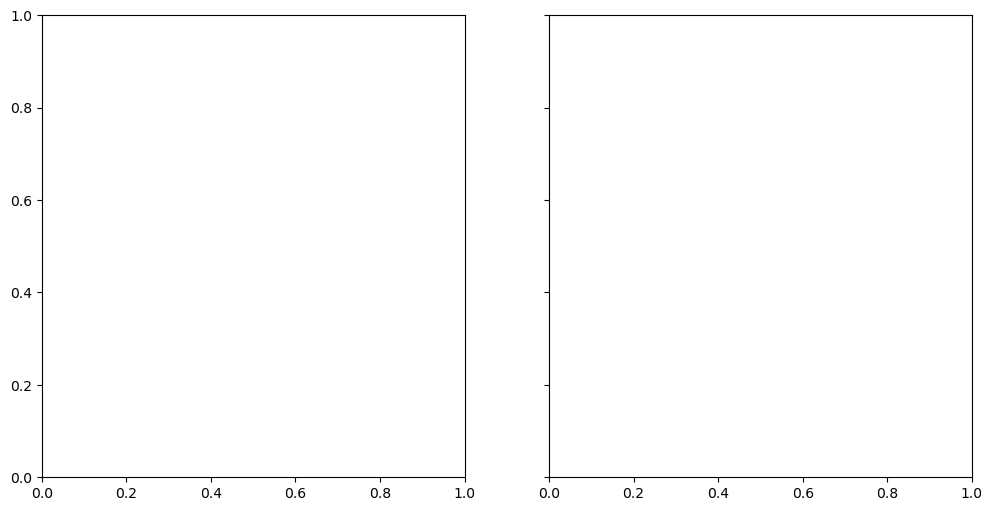

In [ ]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for sit_idx in [1, 4]:
	models, media = load_simple_models(sit_idx)

	f, F = iifba.iipfba(models, media, rel_abund="equal", iters=10) # defualt values

	biomass_id = "exchangeBio1"
	ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sit_idx)
	if sit_idx > 2:
		biomass_id = "exchangeBio2"
		ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sit_idx)
	else:
		ax2 = iifba.iifba_vis(np.zeros(10), ax=ax2, line_lab=sit_idx)



In [1]:
from IPython.display import display
for line in ax1.get_lines():
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2)
for line in ax2.get_lines():
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2)

ax1.get_lines()[2].set_lw(4)# 5 overlaps with 3
ax1.get_lines()[2].set_ls("--")

ax2.get_lines()[3].set_lw(4) # 5 overlaps with 4
ax2.get_lines()[3].set_ls("--")
ax2.get_lines()[2].set_lw(4) # 6 overlaps with 3
ax2.get_lines()[2].set_ls("--")
ax2.get_lines()[0].set_lw(0)
ax2.get_lines()[1].set_lw(0)

# Update legends
ax1.legend(['Situation 1', 'Situation 2', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])
ax2.legend(['Situation 1 (N/A)', 'Situation 2 (N/A)', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])

# Method 3: Get and modify legend properties
legend1 = ax1.get_legend()
legend2 = ax2.get_legend()

# Use display() to show the updated plot
ax1.set_title("Biomass 1")
ax2.set_title("Biomass 2")


fig.tight_layout()
fig.suptitle(r"iiFBA Results for Various Situations")
display(fig)


NameError: name 'ax1' is not defined

## Compartmentalized FBA 

In [4]:
from cobra import Model

for sit_idx in range(1, 7):
	models, media = load_simple_models(sit_idx)
	print(f"\nSituation {sit_idx} Models:")
	for model in models:
		for ex in model.exchanges:
			ex.lower_bound = 0  # Set lower bound to 0 for all exchange reactions
		for med_ex in media.keys():
			if med_ex in model.reactions:
				model.reactions.get_by_id(med_ex).lower_bound = media[med_ex]
				

	for model_idx, model in enumerate(models):
		# Change compartments for each model so that models[i] uses e0 and c{i+1} compartments
		for met in model.metabolites:
			if met.compartment == "c":
				met.compartment = f"c{model_idx+1}"
				id = met.id.replace("bio1", "bio_c").replace("bio2", "bio_c").replace("_c", f"_c{model_idx+1}")
				met.id = id
		
		for rxn in model.reactions:
			# Change the compartment of the reaction to match the new metabolite compartments
			for met in rxn.metabolites.copy():
				if met.compartment.startswith("c"):
					if not rxn.id.endswith(f"_{met.compartment}"):
					# Find the metabolite object with the new id in the model
						rxn.id = rxn.id + f"_{met.compartment}"

	# Merge the two models into a single compartmentalized model
	comp_model = Model(f"compartmentalized_sit{sit_idx+1}")
	for m in models:
		comp_model.add_metabolites([met.copy() for met in m.metabolites])
		comp_model.add_reactions([rxn.copy() for rxn in m.reactions])


	# Example: print the objective value after optimizing the compartmentalized model
	objective_reactions = [comp_model.reactions.get_by_id(f"exchangeBio{i+1}_c{i+1}") for i in range(len(models))]
	objective_rxns_coef = [1] * len(objective_reactions)

			
	comp_model.objective = dict(zip(objective_reactions, objective_rxns_coef))

	solution = comp_model.optimize()
	print(f"{comp_model.id}, Objective value: {solution.objective_value}")
	print(solution.fluxes)

Ignoring reaction 'Ex_A' since it already exists.
Ignoring reaction 'Ex_A' since it already exists.
Ignoring reaction 'Ex_B' since it already exists.
Ignoring reaction 'Ex_B' since it already exists.



Situation 1 Models:
compartmentalized_sit2, Objective value: 10.0
Ex_A              -10.0
T_A_c1             10.0
BiomassOrg1_c1     10.0
exchangeBio1_c1    10.0
Name: fluxes, dtype: float64

Situation 2 Models:
compartmentalized_sit3, Objective value: 20.0
Ex_A              -10.0
Ex_B                0.0
T_A_c1             10.0
T_B_c1              0.0
BiomassFromA_c1    10.0
BiomassFromB_c1    10.0
exchangeBio1_c1    20.0
Name: fluxes, dtype: float64

Situation 3 Models:
compartmentalized_sit4, Objective value: 10.0
Ex_A              -10.0
T_A_c1              0.0
BiomassOrg1_c1      0.0
exchangeBio1_c1     0.0
T_A_c2             10.0
BiomassOrg2_c2     10.0
exchangeBio2_c2    10.0
Name: fluxes, dtype: float64

Situation 4 Models:
compartmentalized_sit5, Objective value: 20.0
Ex_A              -10.0
T_A_c1             10.0
BiomassOrg1_c1     10.0
exchangeBio1_c1    10.0
Ex_B              -10.0
T_B_c2             10.0
BiomassOrg2_c2     10.0
exchangeBio2_c2    10.0
Name: fluxes, dtype: 

**Sit 1 & 2 :**
Matches

**Sit 3:**
Kinda Matches (obj matches, but flux divided incorrectly)
Degenerate solution so any division of metA functions equally (all to the first is simplest)

**Sit 4:**
Matches

**Sit 5:**
Wrong because doesnt account for BiomassFromA_c2 using some A before BiomassFromA_c1 can get to it... 15 iiFBA makes more sense

**Sit 6:**
Matches

situation   iifba bio1   cfba bio1   iifba bio2     cfba bio2       iifba sum    cfba sum
1               10          10          na              na              10          10
2               20          20          na              na              20          20
3               5           10          5               0               10          10
4               10          10          10              10              20          20
5               5           10          10              10              15          20  
6				20			20			10				10				30			30

## MICOM


In [32]:
import pandas as pd
import cobra
from cobra.util.solver import linear_reaction_coefficients 
models, media = load_simple_models(3)

community = pd.DataFrame({
	"id": ["Org1", "Org2"],
	"file": ["../Examples/SImple_Models/sit_III_1.json", "../Examples/SImple_Models/sit_III_2.json"],
	"abundance": [0.2, 0.8]
})

media = {"EX_A_m": 10}
from micom import Community
import micom
community = Community(community)

community.medium = media
community.solver = "gurobi"



solutions = community.cooperative_tradeoff(fraction=[1,0.8, 0], pfba=True)
for idx, sol in enumerate(solutions["solution"]):
	print(f"Solution alpha: {solutions['tradeoff'][idx]}")
	print(sol.members)
	#print("End Abundances:", (sol.members["abundance"] * sol.members["growth_rate"]).to_numpy()[0:-1])
	print("-" * 60)

for rxn in community.reactions:
	print(rxn)

print((community.reactions.get_by_id("Ex_A__Org1").metabolites))

Output()

[07/08/25 11:30:16] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=20491;file:///home/rseag/anaconda3/envs/MBE2/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=463716;file:///home/rseag/anaconda3/envs/MBE2/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

Solution alpha: 1.0
              abundance  growth_rate  reactions  metabolites
compartments                                                
Org1                0.2     2.941176          4            3
Org2                0.8    11.764706          4            3
medium              NaN          NaN          1            1
------------------------------------------------------------
Solution alpha: 0.8
              abundance  growth_rate  reactions  metabolites
compartments                                                
Org1                0.2     2.352941          4            3
Org2                0.8     9.411765          4            3
medium              NaN          NaN          1            1
------------------------------------------------------------
Solution alpha: 0.0
              abundance  growth_rate  reactions  metabolites
compartments                                                
Org1                0.2     0.000004          4            3
Org2                0.8  

Iterations set to: 10
Relative abundances set to: [0.2 0.8]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


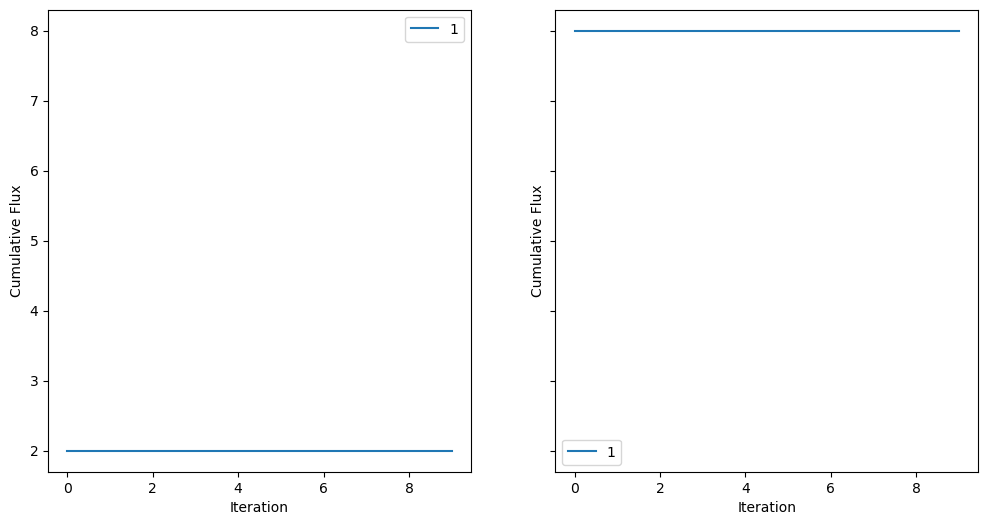

In [16]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

models, media = load_simple_models(3)

f, F = iifba.iipfba(models, media, rel_abund=[0.2,0.8], iters=10) # defualt values

biomass_id = "exchangeBio1"
ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sit_idx)

biomass_id = "exchangeBio2"
ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sit_idx)
